In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

In [2]:
# import logging
# logging.basicConfig(level=logging.DEBUG)  # Change from INFO to DEBUG

In [3]:
import pandas as pd
from signal_processing.signal_pipeline import SignalPipeline
from signal_processing.report_generator import generate_quality_report
from signal_processing.wavelet_denoise import WaveletProcessor
from signal_processing.motion_removal import AdaptiveFilter

In [4]:
import pandas as pd
import numpy as np

In [5]:
unified_df = pd.read_parquet("../data/processed/unified_dataset.parquet")

In [6]:
from scipy.signal import find_peaks
test_signal = np.sin(2*np.pi*1*np.linspace(0,1,30)) + 0.2*np.random.randn(30)
peaks, _ = find_peaks(test_signal, height=0.6, distance=15, prominence=0.2)
print(f"Detected {len(peaks)} peaks")  # Should find 1-2 peaks

Detected 1 peaks


In [7]:
# Test with sample data
test_signal = np.sin(2*np.pi*1*np.linspace(0,1,30)) + 0.2*np.random.randn(30)

# Pulse rate calculation
pulse_rate = SignalPipeline()._compute_pulse_rate(test_signal)
print(f"Pulse Rate Length: {len(pulse_rate)} (matches input {len(test_signal)})")

# Wavelet denoising
denoised = WaveletProcessor(wavelet_level=5).denoise(test_signal, 'III-IV')
print(f"Denoised Length: {len(denoised)}")

Pulse Rate Length: 30 (matches input 30)
Denoised Length: 30


In [8]:
short_signal = np.random.randn(3)
acc = np.random.randn(3, 3)
filtered = AdaptiveFilter().apply_lms(short_signal, acc)  # Now returns original
print(f"Filtered length: {len(filtered)}")  # Output: 3

Filtered length: 3


In [9]:
# Find windows that DO contain clean data
has_clean = unified_df[unified_df['device'] == 'clean']
valid_window = has_clean.index.min(), has_clean.index.max()
print(f"Clean data exists between {valid_window[0]} and {valid_window[1]}")

# Select test window within this range
test_data = unified_df[
    (unified_df.index >= '2020-01-03 09:00:00+00:00') &  # Example time
    (unified_df.index < '2020-01-03 09:00:10+00:00')
]
pipeline = SignalPipeline()
result = pipeline._process_group(test_data)




Clean data exists between 2020-01-03 08:00:00+00:00 and 2025-02-21 01:38:51.840681+00:00
Possible causes: 1) Misalignment 2) Over-filtering 3) Hardware mismatch
Aligned baseline samples: 900
Signal power: 147.8089, Noise power: 10844.1699
SNR: -18.7 dB
Possible causes: 1) Misalignment 2) Over-filtering 3) Hardware mismatch
Aligned baseline samples: 900
Signal power: 147.8089, Noise power: 13351.9154
SNR: -19.6 dB


In [10]:
# Check baseline-device timing offsets
time_diffs = (test_data.index.to_series().diff().dt.total_seconds())
print(f"Sampling interval stats:\n{time_diffs.describe()}")
# Should show ~0.033s (30Hz) intervals consistently

Sampling interval stats:
count    2099.000000
mean        0.004748
std         0.011655
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.034000
dtype: float64


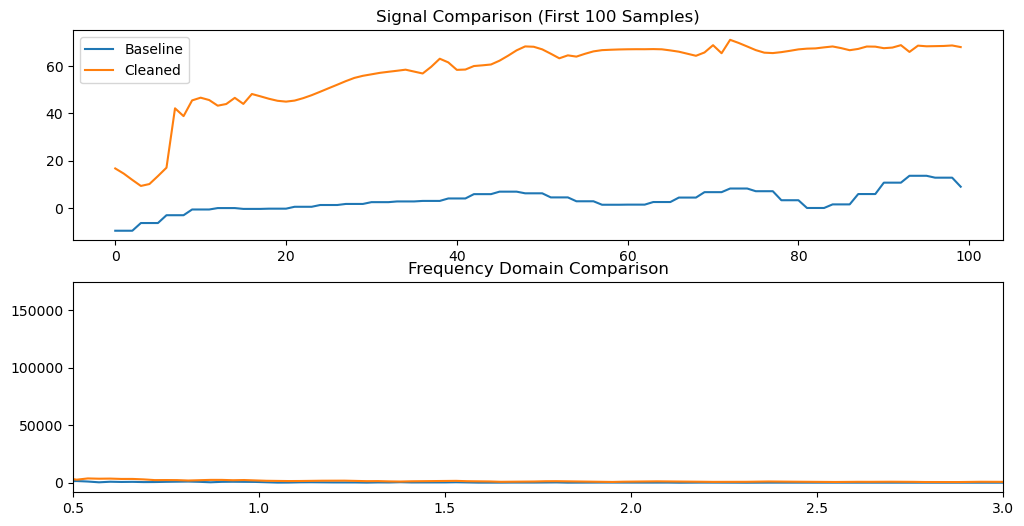

In [11]:
# Plot baseline vs cleaned signals
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(result['baseline'].values[:100], label='Baseline')
ax[0].plot(result['bvp_clean'].values[:100], label='Cleaned')
ax[0].set_title("Signal Comparison (First 100 Samples)")
ax[0].legend()

# Plot frequency spectra
f = np.fft.rfftfreq(1000, 1/30)
ax[1].plot(f, np.abs(np.fft.rfft(result['baseline'].values[:1000])))
ax[1].plot(f, np.abs(np.fft.rfft(result['bvp_clean'].values[:1000])))
ax[1].set_xlim(0.5, 3)  # Heart rate range
ax[1].set_title("Frequency Domain Comparison")
plt.show()

DC Offset: 26.96 (Should be near 0)
Signal-to-Noise Ratio: -19.2 dB


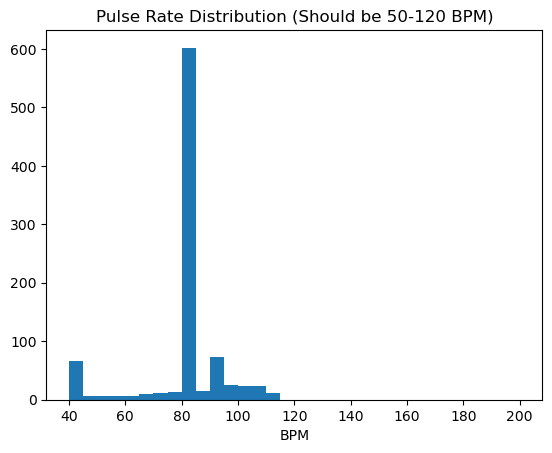

In [12]:
offset = np.median(np.concatenate([result['baseline'], result['bvp_clean']]))
print(f"DC Offset: {offset:.2f} (Should be near 0)")

plt.hist(result['bvp_pulse_rate'], bins=np.arange(40,201,5))
plt.title("Pulse Rate Distribution (Should be 50-120 BPM)")
plt.xlabel("BPM")

clean_std = result['baseline'].std()
noise_std = (result['bvp_clean'] - result['baseline']).std()
print(f"Signal-to-Noise Ratio: {20*np.log10(clean_std/noise_std):.1f} dB")

In [13]:
print(result.columns)  # Should now include 'snr_improvement'
# 2. Verify outputs
print("\nFinal Results:")
print(f"Baseline samples: {result['baseline'].notna().sum()}")
print(f"SNR Improvement: {result['snr_improvement'].mean():.1f} dB")

# 3. Safe value inspection
valid_samples = result[result['baseline'].notna()]
if not valid_samples.empty:
    sample = valid_samples.iloc[0]  # Get first valid row
    print(f"\nExample Comparison:")
    print(f"Baseline value: {sample['baseline']:.4f}")
    print(f"Cleaned value: {sample['bvp_clean']:.4f}")
    print(f"Difference: {sample['bvp_clean'] - sample['baseline']:.4f}")
else:
    print("\nNo baseline data available for comparison")

# 4. Pulse rate verification
print(f"\nPulse Rate Stats:")
print(f"Average: {result['bvp_pulse_rate'].mean():.1f} BPM")
print(f"Range: {result['bvp_pulse_rate'].min():.1f}-{result['bvp_pulse_rate'].max():.1f} BPM")

Index(['label', 'subject_id', 'dataset', 'device', 'skin_tone', 'noise_level',
       'acc_x', 'acc_y', 'acc_z', 'baseline', 'bvp_clean', 'bvp_pulse_rate',
       'snr_improvement'],
      dtype='object')

Final Results:
Baseline samples: 1800
SNR Improvement: -19.1 dB

Example Comparison:
Baseline value: -9.6400
Cleaned value: 16.7271
Difference: 26.3671

Pulse Rate Stats:
Average: 80.4 BPM
Range: 40.0-112.5 BPM
